In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict


In [16]:
def export_figure (title):
    plt.tight_layout()
    plt.savefig(os.path.join("figs", title + ".eps"))
    plt.show()

In [17]:
def make_code_columns(raw_coded):
    meta_cols = []
    coder_cols = []
    renamer = {}
    for col in raw_coded.columns:
        shortened = col
        if col[0:3] == "[M]":
            shortened = col[4:-2]
            meta_cols.append(shortened)
        if col[0:3] == "[C]":
            shortened = col[3:]
            coder_cols.append(shortened)
        renamer[col] = shortened


    # first two meta columns are elective code and institution, which we use as the index
    # third meta column is title
    index_cols = meta_cols[0:3]
    keep_cols = index_cols + coder_cols
    base = raw_coded.rename(columns=renamer)[keep_cols]

    long1 = base.melt(index_cols)
    long1.value = long1.value.str.replace(" ","")
    long1.value = long1.value.str.pad(width=2, side='left', fillchar='0')
    long1.value = long1.value.str.replace("00","")

    long2 = long1.join(long1['value'].str.split(';', expand=True))
    long3 = long2.drop('value', axis=1)
    long3 = long3.rename(columns={'variable': 'coder'})

    long4 = long3.melt(index_cols + ['coder'])
    long4 = long4.rename(columns={'value': 'code'})[index_cols + ['coder','code']]
    long4.fillna("",inplace = True)
    long4 = long4[long4.code.str.len()>0]

    long5 = long4.groupby(index_cols + ['code']).count().unstack().fillna(0)
    long5.columns = long5.columns.get_level_values(1)
    return long5



In [18]:
def has_agreement_inset_code(code_in_columns, value_set, code):
    return code_in_columns[code].isin(value_set)

def has_agreement_inset_any_code(code_in_columns, value_set):
    has_agreement = False
    for col in code_in_columns.columns:
        has_agreement = has_agreement | has_agreement_inset_code(code_in_columns, value_set, col)
    return has_agreement

def has_agreement_4_plus_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [4,5,6,7], code)

def has_agreement_23_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [2,3], code)

def has_agreement_3_code(code_in_columns, code):
    return has_agreement_inset_code(code_in_columns, [3], code)

def has_agreement_4_plus_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [4,5,6,7])

def has_agreement_23_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [2,3])

def has_agreement_3_any_code(code_in_columns):
    return has_agreement_inset_any_code(code_in_columns, [3])

def has_good_overall_agreement_code(code_in_columns, code):
    return (has_agreement_4_plus_code(code_in_columns, code)) & ~(has_agreement_23_code(code_in_columns, code))

def has_good_overall_agreement_any_code(code_in_columns):
    return (has_agreement_4_plus_any_code(code_in_columns)) & ~(has_agreement_23_any_code(code_in_columns))

def has_some_overall_agreement_code(code_in_columns, code):
    return (has_agreement_4_plus_code(code_in_columns, code)) & ~(has_agreement_3_code(code_in_columns, code))

def has_some_overall_agreement_any_code(code_in_columns):
    return (has_agreement_4_plus_any_code(code_in_columns)) & ~(has_agreement_3_any_code(code_in_columns))


In [19]:
stage_one_files = ["20230622WG6_AllElectivesPart1-stage1.csv", "20230622WG6_AllElectivesPart2-stage1.csv", "20230622WG6_AllElectivesPart3-stage1.csv", "20230825WG6_AllElectivesPart4-stage1.csv"]

stage_one_contents = []
for stage_one_file in stage_one_files:
    raw = pd.read_csv(os.path.join("coded", stage_one_file), dtype='string').fillna("")
    raw = raw.replace("Edinburgh_UK", "Edinburgh_Scotland")
    raw = raw.replace("\n"," ")
    stage_one_contents.append(raw)
raw_coded = pd.concat(stage_one_contents)
raw_coded.to_csv(os.path.join("coded","stage1_codes_raw.csv"))

code_in_columns = make_code_columns(raw_coded)
code_in_columns.to_csv(os.path.join("coded","stage1_codes_columns.csv"))
#code_in_columns[code_in_columns['elective']=="COMP3467"]


In [20]:
# update the elective coding with a specific subset (rows: institution and elective, columns: topics/application areas)
def add_coding (original, update):
    # from https://stackoverflow.com/questions/38543263/pandas-multiply-all-the-numeric-values-in-the-data-frame-by-a-constant
    update[update.select_dtypes(include=['number']).columns] *= 7
    key_columns = ['institution', 'elective']
    updated_columns = list(set(update.columns) - set(key_columns))
#    print (updated_columns, "updated columns for ", stage_two_file)
    joined = original.merge(update, on=key_columns, how='left')
    for updated_column in updated_columns:
        try:
            joined[updated_column+"_y"] = joined[updated_column+"_y"].fillna(joined[updated_column+"_x"])
        except BaseException:
            print ("Exception")
            print ("joined _y",joined[updated_column+"_y"])
            print ("joined _x",joined[updated_column+"_x"])
            break
        joined[updated_column] = joined[updated_column+"_y"].astype('float')
        joined.drop(columns=[updated_column + "_x", updated_column + "_y"], inplace=True)
    return joined.fillna(0)

In [21]:
types = defaultdict(float, institution='str', elective='str')
test = pd.read_csv(os.path.join("coded","stage1_codes_columns.csv"), dtype = types, keep_default_na=False)
test = test[test['institution'] == "CAU_Germany"]
print(test)
test_no_match = pd.DataFrame({"elective":["1DL034"], "institution":["Upps4l4_Sweden"], "PDC":[1]})
test_update = pd.DataFrame({"elective":["1DL034"], "institution":["Uppsala_Sweden"], "PDC":[1]})
test_no_majority = pd.read_csv(os.path.join("coded", "stage2", "stage2_codes_no_majority.csv"), dtype = types, keep_default_na=False)

test_result = add_coding(test, test_no_majority)
test_result[["elective", "17"]]

          elective  institution  \
185  Inf-CombWords  CAU_Germany   
186     Inf-DigSig  CAU_Germany   
187  Inf-GraphDraw  CAU_Germany   
188       Inf-NNDL  CAU_Germany   
189    Inf-NumProg  CAU_Germany   
195      WInf-eBeM  CAU_Germany   
270    inf-AuLearn  CAU_Germany   
271         inf-CI  CAU_Germany   
272       inf-EAeS  CAU_Germany   
273       inf-EERP  CAU_Germany   
274     inf-EnlOpt  CAU_Germany   
275        inf-IoT  CAU_Germany   
276         inf-TM  CAU_Germany   

                                                 title   01   02   03   04  \
185                             Combinatorics on Words  0.0  0.0  0.0  0.0   
186  Multimedia Signal Processing and Data Compression  0.0  0.0  1.0  0.0   
187                            Automatic Graph Drawing  0.0  0.0  0.0  0.0   
188                  Neural networks and deep learning  0.0  0.0  0.0  0.0   
189                              Numerical Programming  0.0  0.0  0.0  0.0   
195                         E-Business un

,elective,17
0,Inf-CombWords,0.0
1,Inf-DigSig,0.0
2,Inf-GraphDraw,0.0
3,Inf-NNDL,0.0
4,Inf-NumProg,0.0
5,WInf-eBeM,7.0
6,inf-AuLearn,0.0
7,inf-CI,0.0
8,inf-EAeS,0.0
9,inf-EERP,4.0


In [22]:
types = defaultdict(float, institution='str', elective='str')

stage_two = pd.read_csv(os.path.join("coded","stage1_codes_columns.csv"), dtype = types, keep_default_na=False)


print(len(stage_two.columns))
stage_two_files = ["stage2_codes_columns-DM.csv",
                   "stage2_codes_columns-SDF.csv",
                   "stage2_codes_columns-AL.csv",
                   "stage2_codes_columns-SE-SP.csv",
                   "stage2_codes_columns-SPD.csv",
                   "stage2_codes_columns-FPL.csv",
                   "stage2_codes_columns-MSF.csv",
                   "stage2_codes_columns-GIT.csv",
                   "stage2_codes_columns-CAH.csv",
                   "stage2_codes_columns-OS.csv",
                   "stage2_codes_columns-AI.csv",
                   "stage2_codes_columns-AR.csv",
                   "stage2_codes_columns-SEC.csv"
                   ,"stage2_codes_no_majority.csv"
                  ]
for stage_two_file in stage_two_files:
    stage_two_addition = pd.read_csv(os.path.join("coded", "stage2", stage_two_file), dtype = types, keep_default_na=False)
    stage_two_addition = stage_two_addition.replace("Edinburgh_UK", "Edinburgh_Scotland")
    stage_two = add_coding(stage_two, stage_two_addition)
    
stage_two.to_csv(os.path.join("coded","stage2_codes_columns.csv"))

38


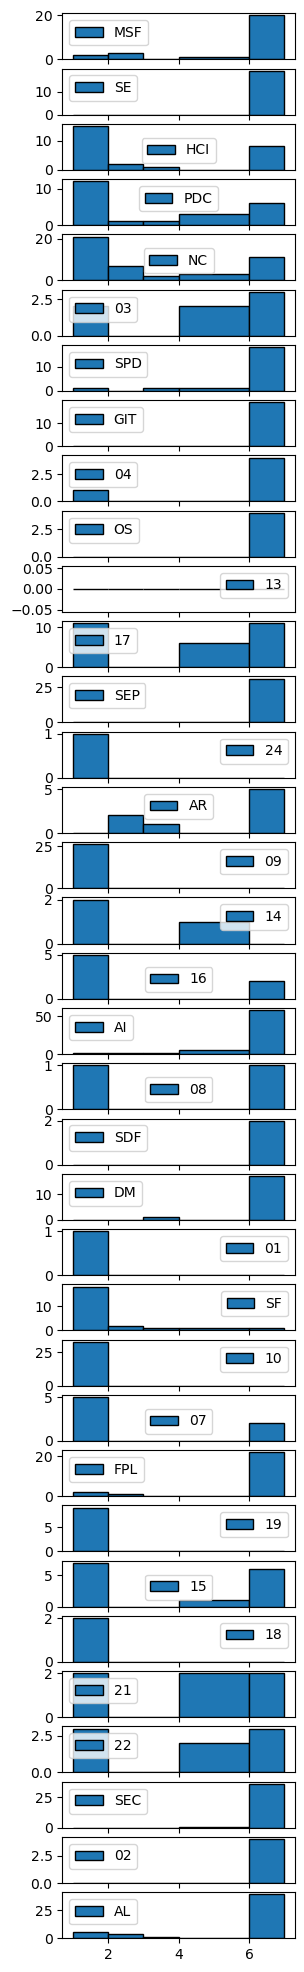

In [23]:
cols_to_plot = stage_two.columns[3:]

fig, axs = plt.subplots(len(cols_to_plot), figsize=(3, 25))
for n, col in enumerate(cols_to_plot):
    stage_two[col].replace(0, np.nan).hist(ax=axs[n], bins=[1,2,3,4,6,7],  edgecolor='black', grid=False, legend=True)



Suggestions for more stage 2 coding: 
* AI
* MSF
* FPL

Still some CAH data to come, but possibly
* 22 (education)
* 15 (social sciences)
* 14 (humanities and libreal arts)


In [24]:
stage_two[~has_good_overall_agreement_any_code(stage_two)]

,elective,institution,title,MSF,SE,HCI,PDC,NC,03,SPD,...,07,FPL,19,15,18,21,22,SEC,02,AL
17,5.587,UOC_Spain,Software engineering of components and distrib...,0.0,7.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,COMP3491,Durham_England,COMP3491: CODES AND CRYPTOGRAPHY,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
51,COMP3617,Durham_England,COMP3617: VIRTUAL AND AUGMENTED REALITY,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78,COMPSCI4031,Glasgow_Scotland,Modelling Reactive Systems (H) COMPSCI4031,0.0,0.0,0.0,4.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,COMPSCI4077,Glasgow_Scotland,Web Science (H) COMPSCI4077,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
93,COMPSCI4089,Glasgow_Scotland,Advanced Systems Programming (H) COMPSCI4089,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,CS3744,VirginiaTech_USA,Introduction to GUI Programming and Graphics,7.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,CS4284,VirginiaTech_USA,Systems & Networking Capstone,0.0,0.0,0.0,2.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,CS4504,VirginiaTech_USA,Computer Organization,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,CS4626,Kennesaw_USA,Computer and Network Security,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [25]:
stage_two[~has_some_overall_agreement_any_code(stage_two)]

,elective,institution,title,MSF,SE,HCI,PDC,NC,03,SPD,...,07,FPL,19,15,18,21,22,SEC,02,AL
17,5.587,UOC_Spain,Software engineering of components and distrib...,0.0,7.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,COMP3617,Durham_England,COMP3617: VIRTUAL AND AUGMENTED REALITY,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
126,CS4626,Kennesaw_USA,Computer and Network Security,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
162,CYBR4893,Kennesaw_USA,Internet of Things: Applications and Security,0.0,0.0,0.0,0.0,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
199,cxinfr09042,Edinburgh_Scotland,Undergraduate Course: Automated Reasoning (INF...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
210,cxinfr10076,Edinburgh_Scotland,Undergraduate Course: Computer Architecture an...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,cxinfr11092,Edinburgh_Scotland,Postgraduate Course: Robotics: Science and Sys...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,cxinfr11222,Edinburgh_Scotland,Postgraduate Course: Introduction to Quantum C...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
264,cxinfr11229,Edinburgh_Scotland,Undergraduate Course: Text Technologies for Da...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
stage_two[~has_agreement_4_plus_any_code(stage_two)]

,elective,institution,title,MSF,SE,HCI,PDC,NC,03,SPD,...,07,FPL,19,15,18,21,22,SEC,02,AL
199,cxinfr09042,Edinburgh_Scotland,Undergraduate Course: Automated Reasoning (INF...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
227,cxinfr11092,Edinburgh_Scotland,Postgraduate Course: Robotics: Science and Sys...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,cxinfr11222,Edinburgh_Scotland,Postgraduate Course: Introduction to Quantum C...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
264,cxinfr11229,Edinburgh_Scotland,Undergraduate Course: Text Technologies for Da...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
def electives_with_codes(codes):
    code_in_columns = pd.read_csv(os.path.join("coded","stage1_codes_columns.csv"))
    has_a_code = False
    for code in codes:
        has_a_code = has_a_code | (code_in_columns[code] > 0)
    index_of_electives_with_code = code_in_columns[has_a_code][['institution','elective','title']]
    def row_included(row):
        this_inst = row.institution
        this_elective = row.elective
        return index_of_electives_with_code[(index_of_electives_with_code.institution == this_inst) &
                                           (index_of_electives_with_code.elective == this_elective)]['elective'].count() >0
    all_electives = pd.read_csv("all_electives.csv")
    return all_electives[all_electives.apply(row_included, axis=1)]
#    return all_electives.apply(row_included, axis=1)

In [18]:
all_electives_enrolment = pd.read_csv(os.path.join("..", "enrolment", "all_elective_enrolment_rounded.csv"))
stage_two_enrolment = stage_two.merge(all_electives_enrolment, left_on=['institution','elective'], right_on=['institution','MCode'], how='left')
stage_two_enrolment.sort_values('Students3', ascending=False)
stage_two_enrolment[stage_two_enrolment['institution'] == "UOC_Spain"].head(100)
stage_two_enrolment.to_csv("stage_two_enrolment.csv")
#stage_two_enrolment.columns
#all_electives_enrolment

In [19]:
all_cohorts_enrolment = pd.read_csv(os.path.join("..", "enrolment","all_cohort_enrolment_rounded.csv"))
all_cohorts_enrolment.sort_values('Men3', ascending=False)
all_cohorts_enrolment['Men3'].sum() + all_cohorts_enrolment['Women3'].sum()

23096

In [20]:
stage_two_enrolment_cohort = stage_two_enrolment.merge(all_cohorts_enrolment, on=['Cohort','institution','AcademicYearStart'], how='left')
stage_two_enrolment_cohort[stage_two_enrolment_cohort['institution'] == "UOC_Spain"]

,elective,institution,title,SDF,MSF,07,HCI,14,08,10,...,MCode,Cohort,AcademicYearStart,Women3_x,Men3_x,Cap,Students3,Women3_y,Men3_y,MaxElectives
14,22.4,UOC_Spain,Computational thinking,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.4,1,2022.0,42.0,123.0,NaN,165.0,306.0,2170.0,29.0
15,5.574,UOC_Spain,Computer networks security,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.574,1,2020.0,9.0,123.0,NaN,132.0,234.0,1780.0,28.0
16,5.574,UOC_Spain,Computer networks security,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.574,1,2021.0,12.0,120.0,NaN,132.0,268.0,1942.0,28.0
17,5.574,UOC_Spain,Computer networks security,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.574,1,2022.0,9.0,144.0,NaN,153.0,306.0,2170.0,29.0
18,5.576,UOC_Spain,Computer networks design,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.576,1,2020.0,9.0,81.0,NaN,90.0,234.0,1780.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,5.614,UOC_Spain,Introduction to mathematics for engineering,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,5.614,1,2021.0,126.0,747.0,NaN,873.0,268.0,1942.0,28.0
95,5.614,UOC_Spain,Introduction to mathematics for engineering,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,5.614,1,2022.0,126.0,801.0,NaN,927.0,306.0,2170.0,29.0
96,5.672,UOC_Spain,Business practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.672,1,2020.0,3.0,18.0,NaN,21.0,234.0,1780.0,28.0
97,5.672,UOC_Spain,Business practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.672,1,2021.0,6.0,27.0,NaN,33.0,268.0,1942.0,28.0


In [21]:
stage_two_enrolment_collapsed = stage_two_enrolment_cohort.groupby('elective')[['Women3_x', 'Men3_x', 'Women3_y', 'Men3_y']].sum()
stage_two_enrolment_collapsed.to_csv("stage_two_enrolment_collapsed.csv")
stage_two_enrolment_collapsed

,Women3_x,Men3_x,Women3_y,Men3_y
elective,,,,
1DL034,63.0,219.0,129.0,394.0
1DL231,0.0,0.0,0.0,0.0
1DL311,0.0,0.0,0.0,0.0
1DT075,33.0,123.0,129.0,394.0
1TD062,63.0,219.0,129.0,394.0
...,...,...,...,...
inf-EAeS,9.0,30.0,39.0,168.0
inf-EERP,15.0,51.0,39.0,168.0
inf-EnlOpt,3.0,24.0,39.0,168.0


In [55]:

stage_two = pd.read_csv(os.path.join("coded","stage2_codes_columns.csv"))
all_electives = pd.read_csv(os.path.join("..", "curriculum_content", "all_electives.csv"))
all_electives_coded = all_electives.merge(stage_two, on=['institution', 'elective'], how='left')
all_electives_coded[all_electives_coded['SDF'].isnull()]

,institution,elective,overview,title_x,summary,content,ilo,Unnamed: 0,title_y,SDF,...,18,AR,13,15,16,SPD,OS,17,21,01
3,Durham_England,COMP3467,<h2>Durham_England COMP3467</h2><h2>title</h2>...,COMP3467: \nADVANCED COMPUTER SYSTEMS,\n\t\t\t<li> To provide understanding of the r...,\n\t\t\t<li> Computer Architecture including c...,"\n\t\t\t\t<li>On completion of the module, stu...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,Edinburgh_Scotland,cxinfr11220,<h2>Edinburgh_Scotland cxinfr11220</h2><h2>tit...,Undergraduate Course: Computer Graphics (Level...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,Edinburgh_Scotland,cxinfr11221,<h2>Edinburgh_Scotland cxinfr11221</h2><h2>tit...,Undergraduate Course: Introduction to Modern C...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,Edinburgh_Scotland,cxinfr11222,<h2>Edinburgh_Scotland cxinfr11222</h2><h2>tit...,Undergraduate Course: Introduction to Quantum ...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Edinburgh_Scotland,cxinfr11223,<h2>Edinburgh_Scotland cxinfr11223</h2><h2>tit...,Undergraduate Course: Machine Learning Practic...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,Edinburgh_Scotland,cxinfr11224,<h2>Edinburgh_Scotland cxinfr11224</h2><h2>tit...,Undergraduate Course: Machine Learning Theory ...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,Edinburgh_Scotland,cxinfr11226,<h2>Edinburgh_Scotland cxinfr11226</h2><h2>tit...,Undergraduate Course: Parallel Programming Lan...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Edinburgh_Scotland,cxinfr11227,<h2>Edinburgh_Scotland cxinfr11227</h2><h2>tit...,Undergraduate Course: Quantum Cyber Security (...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Edinburgh_Scotland,cxinfr11228,<h2>Edinburgh_Scotland cxinfr11228</h2><h2>tit...,Undergraduate Course: Security Engineering (UG...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,Edinburgh_Scotland,cxinfr11229,<h2>Edinburgh_Scotland cxinfr11229</h2><h2>tit...,Undergraduate Course: Text Technologies for Da...,This course follows the delivery and assessmen...,\n \n This course follows the delivery a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
all_electives[all_electives.duplicated(['elective'], keep=False)].sort_values('elective')

,institution,elective,overview,title,summary,content,ilo
277,VirginiaTech_USA,CS4134,<h2>VirginiaTech_USA CS4134</h2><h2>title</h2>...,Quantum Computation and Information Processing,NaN,Quantum states and quantum phenomena. Quantum ...,NaN
285,VirginiaTech_USA,CS4134,<h2>VirginiaTech_USA CS4134</h2><h2>title</h2>...,Quantum Computation and Information Processing,NaN,Quantum states and quantum phenomena. Quantum ...,NaN
286,VirginiaTech_USA,CS4144,<h2>VirginiaTech_USA CS4144</h2><h2>title</h2>...,Competitive Problem Solving II,NaN,"Deeper treatment of advanced algorithms, data ...",NaN
278,VirginiaTech_USA,CS4144,<h2>VirginiaTech_USA CS4144</h2><h2>title</h2>...,Competitive Problem Solving II,NaN,"Deeper treatment of advanced algorithms, data ...",NaN
287,VirginiaTech_USA,CS4234,<h2>VirginiaTech_USA CS4234</h2><h2>title</h2>...,Parallel Computation,NaN,"Survey of parallel computer architectures, mod...",NaN
279,VirginiaTech_USA,CS4234,<h2>VirginiaTech_USA CS4234</h2><h2>title</h2>...,Parallel Computation,NaN,"Survey of parallel computer architectures, mod...",NaN
288,VirginiaTech_USA,CS4254,<h2>VirginiaTech_USA CS4254</h2><h2>title</h2>...,Computer Network Architecture & Programming,NaN,"Introduction to computer network architecture,...",NaN
280,VirginiaTech_USA,CS4254,<h2>VirginiaTech_USA CS4254</h2><h2>title</h2>...,Computer Network Architecture & Programming,NaN,"Introduction to computer network architecture,...",NaN
281,VirginiaTech_USA,CS4264,<h2>VirginiaTech_USA CS4264</h2><h2>title</h2>...,Principles of Computer Security,NaN,Survey of computer security problems and funda...,NaN
289,VirginiaTech_USA,CS4264,<h2>VirginiaTech_USA CS4264</h2><h2>title</h2>...,Principles of Computer Security,NaN,Survey of computer security problems and funda...,NaN


In [58]:
missing_codes = list(all_electives_mcodes - coded_electives_mcodes)
missing_codes

['cxinfr09042',
 'cxinfr11238',
 'cxinfr11225',
 'cxinfr11224',
 'cxinfr11092',
 'cxinfr11222',
 'cxinfr11219',
 'cxinfr11021',
 'cxinfr11226',
 'cxinfr11220',
 'cxinfr11221',
 'cxinfr10069',
 'cxinfr11239',
 'cxinfr11228',
 'cxinfr11227',
 'cxinfr11235',
 'cxinfr11229',
 'cxinfr11223']

In [61]:
missing_electives = all_electives[all_electives['elective'].isin(missing_codes)]
missing_electives.to_csv("20230825missing_electives.csv")